In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense
import warnings

# Suppress warnings for better output readability
warnings.filterwarnings("ignore")


In [2]:
# Load the Excel data
data = pd.read_excel(r"C:\Users\alexm\Desktop\Dissaster Types\Drought.xlsx")
# Step 1: Initial Data Exploration


# Step 2: Handling Missing Values

# Fill missing values in date columns
data['Start Month'] = data['Start Month'].fillna(1).astype(int)  # Default to January
data['Start Day'] = data['Start Day'].fillna(1).astype(int)  # Default to 1st day
data['Start Year'] = data['Start Year'].fillna(2000).astype(int)  # Default to year 2000
data['End Year'] = data['End Year'].fillna(data['Start Year']).astype(int)  # Use Start Year if End Year is missing
data['End Month'] = data['End Month'].fillna(12).astype(int)  # Default to December
data['End Day'] = data['End Day'].fillna(31).astype(int)  # Default to 31st day

# Handle missing values in numeric columns
#numeric_cols = data.select_dtypes(include=np.number).columns
#for col in numeric_cols:
 #   mean_value = data[col].mean()
 #   data[col] = data[col].fillna(mean_value)  # Fill with mean value

# Handle missing values in categorical columns
object_cols = data.select_dtypes(include='object').columns
for col in object_cols:
    if data[col].isnull().any():
        mode_value = data[col].mode()[0]
        data[col] = data[col].fillna(mode_value)  # Replace NaN with mode

# Step 3: Drop Columns That Are Not Needed
# dropping certain columns
import pandas as pd




# Define the updated columns to drop
columns_to_drop = ['Classification Key','Location','OFDA Response', 'Appeal', 'Start Day', 'End Year', 'End Month', 'End Day'
       'Declaration', 'Historic', 'Disaster Group', 'Country', 'Subregion', 'Region','End Day',"Declaration"
    , 'River Basin', 'Disaster Subgroup', 'Last Update', 'Entry Date','Latitude', 'Longitude',"Admin Units" ,"External IDs" ,"Event Name","Origin",
    " External IDs", "Magnitude Scale","No. Affected","No. Injured" , "Total Deaths ","Reconstruction Costs, Adjusted ('000 US$)","Insured Damage, Adjusted ('000 US$)"
,"No. Homeless","Disaster Type","ISO","DisNo."]
# Drop the columns, ignoring errors for non-existent columns
data = data.drop(columns=columns_to_drop, errors='ignore')

# Columns with missing values to fill with 0

columns_with_missing_values = [
    "Reconstruction Costs ('000 US$)", "Total Deaths" ,  "Insured Damage ('000 US$)",  "Total Damage ('000 US$)", 
       "Total Affected",  "AID Contribution ('000 US$)"]

# Fill missing values in the specified columns with 0
data[columns_with_missing_values] = data[columns_with_missing_values].fillna(0)

# Rename the column "Magnitude" to "Magnitude(Scale km2)"
data.rename(columns={"Magnitude": "Magnitude(Scale )"}, inplace=True)

# Verify the changes
print(data[columns_with_missing_values].isnull().sum())  # Should print 0 for all these columns
print(data.columns)  # To check if the column name has been updated


Reconstruction Costs ('000 US$)    0
Total Deaths                       0
Insured Damage ('000 US$)          0
Total Damage ('000 US$)            0
Total Affected                     0
AID Contribution ('000 US$)        0
dtype: int64
Index(['Disaster Subtype', 'Associated Types', 'AID Contribution ('000 US$)',
       'Magnitude(Scale )', 'Start Year', 'Start Month', 'Total Deaths',
       'Total Affected', 'Reconstruction Costs ('000 US$)',
       'Insured Damage ('000 US$)', 'Total Damage ('000 US$)',
       'Total Damage, Adjusted ('000 US$)', 'CPI'],
      dtype='object')


In [3]:
# Columns to convert
columns_to_convert = [
    "Reconstruction Costs ('000 US$)", 
    "Reconstruction Costs, Adjusted ('000 US$)", 
    "Insured Damage ('000 US$)", 
    "Insured Damage, Adjusted ('000 US$)", 
    "Total Damage ('000 US$)", 
    "Total Damage, Adjusted ('000 US$)"
]

# Iterate over the columns and replace their values with those converted to billions
for column in columns_to_convert:
    if column in data.columns:
        data[column] = data[column] / 1e6
        data.rename(columns={column: column.replace("('000 US$)", "(billion $)")}, inplace=True)

# Verify the replacement
print(data.head())



  Disaster Subtype Associated Types  AID Contribution ('000 US$)  \
0          Drought        Heat wave                          0.0   
1          Drought        Heat wave                          0.0   
2          Drought        Heat wave                          0.0   
3          Drought        Heat wave                          0.0   
4          Drought        Heat wave                          0.0   

   Magnitude(Scale )  Start Year  Start Month  Total Deaths  Total Affected  \
0                NaN        2000            5           2.0             0.0   
1            26000.0        2000            6           0.0             0.0   
2                NaN        2000            8           0.0             0.0   
3                NaN        2000            3           0.0             0.0   
4                NaN        2002            5           0.0             0.0   

   Reconstruction Costs (billion $)  Insured Damage (billion $)  \
0                               0.0              

In [4]:
import pandas as pd

# Identify non-numeric columns
non_numeric_columns = data.select_dtypes(include=['object', 'category']).columns

# Apply one-hot encoding to non-numeric columns
data = pd.get_dummies(data, columns=non_numeric_columns, drop_first=True)

# Verify the transformation
print(f"Number of columns after one-hot encoding: {len(data.columns)}")
print("Sample of the transformed DataFrame:")
print(data.head())


Number of columns after one-hot encoding: 14
Sample of the transformed DataFrame:
   AID Contribution ('000 US$)  Magnitude(Scale )  Start Year  Start Month  \
0                          0.0                NaN        2000            5   
1                          0.0            26000.0        2000            6   
2                          0.0                NaN        2000            8   
3                          0.0                NaN        2000            3   
4                          0.0                NaN        2002            5   

   Total Deaths  Total Affected  Reconstruction Costs (billion $)  \
0           2.0             0.0                               0.0   
1           0.0             0.0                               0.0   
2           0.0             0.0                               0.0   
3           0.0             0.0                               0.0   
4           0.0             0.0                               0.0   

   Insured Damage (billion $)  Tot

#MODELS


#Random Forest

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   AID Contribution ('000 US$)          25 non-null     float64
 1   Magnitude                            1 non-null      float64
 2   Start Year                           25 non-null     int64  
 3   Start Month                          25 non-null     int64  
 4   Total Deaths                         25 non-null     float64
 5   Total Affected                       25 non-null     float64
 6   Reconstruction Costs (billion $)     25 non-null     float64
 7   Insured Damage (billion $)           25 non-null     float64
 8   Total Damage (billion $)             25 non-null     float64
 9   Total Damage, Adjusted (billion $)   25 non-null     float64
 10  CPI                                  24 non-null     float64
 11  Associated Types

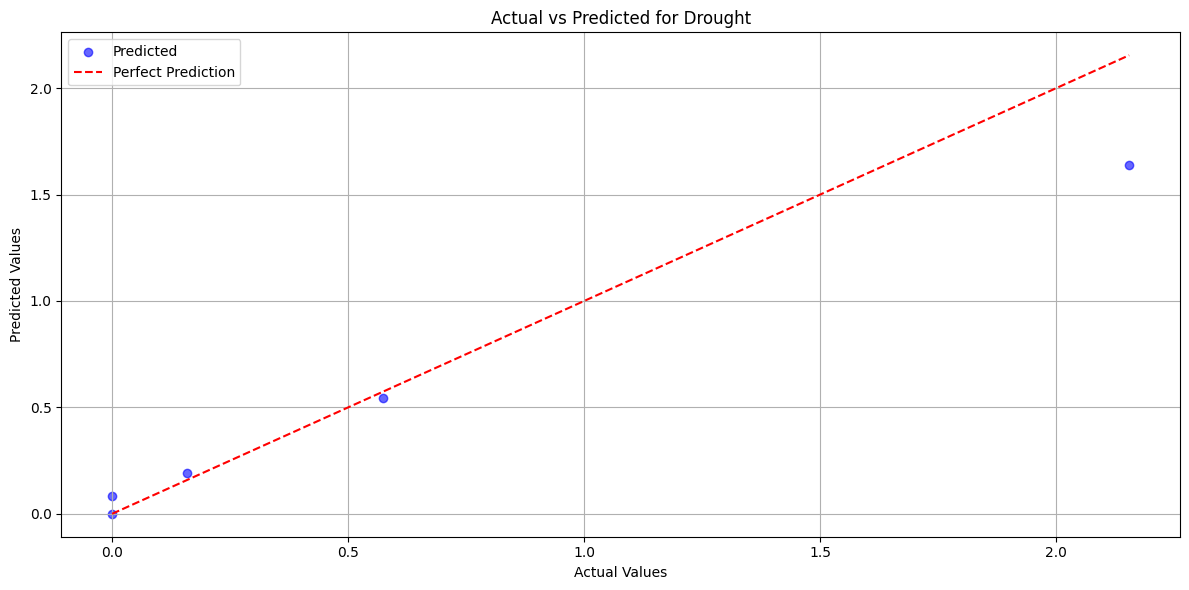

In [8]:
#Random Forest
data = pd.read_excel(r"C:\Users\alexm\Desktop\Dissaster Types\Drought.xlsx")

# --------------------------------
# Fill missing values in date columns
data['Start Month'] = data['Start Month'].fillna(1).astype(int)  
data['Start Day'] = data['Start Day'].fillna(1).astype(int)  
data['Start Year'] = data['Start Year'].fillna(2000).astype(int)  
data['End Year'] = data['End Year'].fillna(data['Start Year']).astype(int)
data['End Month'] = data['End Month'].fillna(12).astype(int)
data['End Day'] = data['End Day'].fillna(31).astype(int)

# Handle missing values in object columns by filling with mode
object_cols = data.select_dtypes(include='object').columns
for col in object_cols:
    if data[col].isnull().any():
        mode_value = data[col].mode()[0]
        data[col] = data[col].fillna(mode_value)

# --------------------------------
# Step 3: Drop Columns That Are Not Needed
# --------------------------------
columns_to_drop = [
    'Classification Key','Location','OFDA Response','Appeal','Start Day','End Year','End Month','End Day' 
    'Declaration','Historic','Disaster Group','Country','Subregion','Region','End Day','Declaration',
    'River Basin','Disaster Subgroup','Last Update','Entry Date','Latitude','Longitude','Admin Units',
    'External IDs','Event Name','Origin',' External IDs','Magnitude Scale','No. Affected','No. Injured',
    'Total Deaths ','Reconstruction Costs, Adjusted (\'000 US$)','Insured Damage, Adjusted (\'000 US$)',
    'No. Homeless','Disaster Type','ISO','DisNo.'
]

data = data.drop(columns=columns_to_drop, errors='ignore')

# --------------------------------
# Step 4: Fill NA with 0 for Certain Columns
# --------------------------------
columns_with_missing_values = [
    "Reconstruction Costs ('000 US$)", 
    "Total Deaths", "Total Damage, Adjusted ('000 US$)", 
    "Insured Damage ('000 US$)",  
    "Total Damage ('000 US$)",
    "Total Affected",  
    "AID Contribution ('000 US$)"
]
for col in columns_with_missing_values:
    if col in data.columns:
        data[col] = data[col].fillna(0)

# --------------------------------
# Step 5: Convert '000 US$ columns to (billion $)
# --------------------------------
columns_to_convert = [
    "Reconstruction Costs ('000 US$)", 
    "Reconstruction Costs, Adjusted ('000 US$)", 
    "Insured Damage ('000 US$)", 
    "Insured Damage, Adjusted ('000 US$)", 
    "Total Damage ('000 US$)", 
    "Total Damage, Adjusted ('000 US$)"
]

for column in columns_to_convert:
    if column in data.columns:
        # Convert from '000 US$ to billion $
        data[column] = data[column] / 1e6  
        new_col = column.replace("('000 US$)", "(billion $)")
        data.rename(columns={column: new_col}, inplace=True)

# At this point, you should have "Total Damage (billion $)" in your DataFrame

# --------------------------------
# Step 6: One-Hot Encoding for Non-Numeric Columns
# --------------------------------
non_numeric_columns = data.select_dtypes(include=['object', 'category']).columns
data = pd.get_dummies(data, columns=non_numeric_columns, drop_first=True)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming the earthquake dataset is loaded into `data`
print("Dataset Overview:")
print(data.info())

# Define the target variable and features
target_column = "Total Damage, Adjusted (billion $)"

X = data.drop(columns=[target_column])
y = data[target_column]

# Confirm all features are numeric
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Proceed if sufficient data is available
if len(X) > 1:
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and fit the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=10, random_state=30)
    rf_model.fit(X_train, y_train)

    # Predict and calculate RMSE
    y_pred = rf_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE for Drought: {rmse:.2f}")

    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Predicted')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
    plt.title("Actual vs Predicted for Drought")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipped analysis due to insufficient samples (n={len(X)})")


NN Deap Learning


Testing configuration: [64, 64, 32]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Configuration [64, 64, 32] - Average RMSE: 0.89
Testing configuration: [128, 64, 32]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Configuration [128, 64, 32] - Average RMSE: 0.90
Testing configuration: [128, 128, 64]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Configuration [128, 128, 64] - Average RMSE: 0.91
Testing configuration: [256, 128, 64]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1

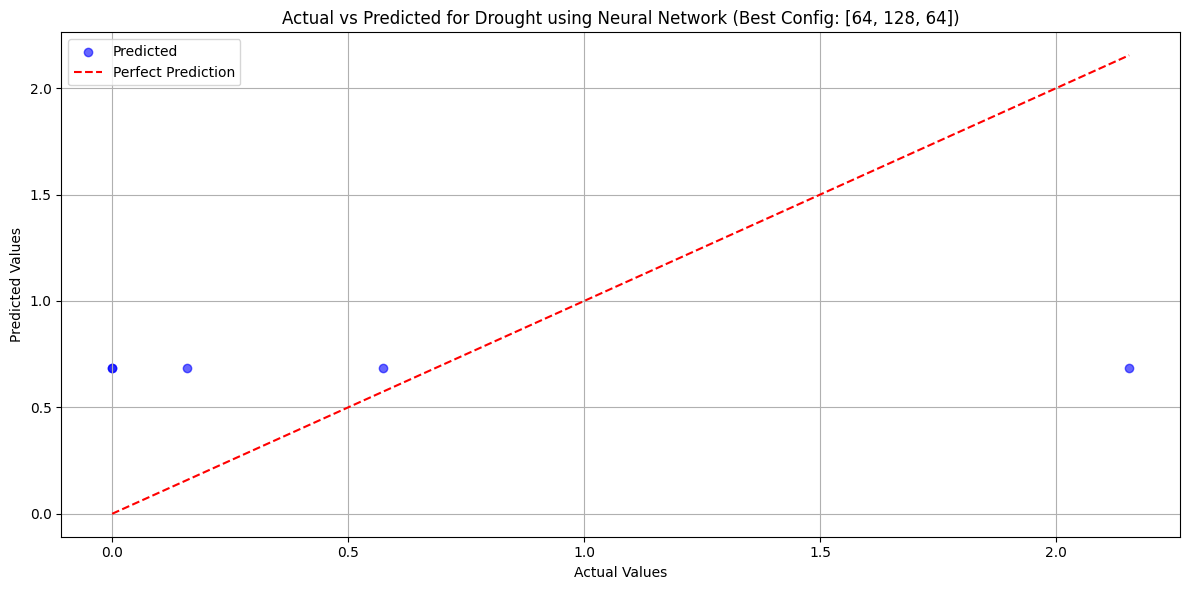

RMSE Results for All Configurations
            Config      RMSE
0     [64, 64, 32]  0.893691
1    [128, 64, 32]  0.895057
2   [128, 128, 64]  0.914157
3   [256, 128, 64]  0.895150
4    [64, 128, 64]  0.890933
5  [128, 128, 128]  0.893176


In [9]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Step 2: Define Features and Target Variable
target_column = "Total Damage, Adjusted (billion $)"
X = data.drop(columns=[target_column])  # Features
y = data[target_column]  # Target

# Step 3: Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Cross-Validation Setup for Experimentation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
neuron_configs = [
    [64, 64, 32],  # Initial configuration (default)
    [128, 64, 32],  # More neurons in the first layer
    [128, 128, 64],  # More neurons in the first and second layers
    [256, 128, 64],  # More neurons across all layers
    [64, 128, 64],  # Increased neurons in the middle layer
    [128, 128, 128]  # Equal large number of neurons in all layers
]

best_config = None
best_rmse = float("inf")
config_rmse_results = []

for config in neuron_configs:
    print(f"Testing configuration: {config}")
    cv_rmse_scores = []
    
    for train_index, val_index in kf.split(X_scaled):
        X_train, X_val = X_scaled[train_index], X_scaled[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Build Neural Network Model
        model = keras.Sequential([
            layers.Input(shape=(X_train.shape[1],)),  # Input layer
            layers.Dense(config[0], activation='relu'),
            layers.Dropout(0.2),  # Regularization
            layers.Dense(config[1], activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(config[2], activation='relu'),
            layers.Dense(1)  # Output layer
        ])

        # Compile the model
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

        # Train the model with Early Stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])

        # Evaluate the model
        y_val_pred = model.predict(X_val).flatten()
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        cv_rmse_scores.append(val_rmse)

    avg_rmse = np.mean(cv_rmse_scores)
    config_rmse_results.append({"Config": config, "RMSE": avg_rmse})
    
    print(f"Configuration {config} - Average RMSE: {avg_rmse:.2f}")

    # Update best configuration
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_config = config

print(f"Best Configuration: {best_config} with RMSE: {best_rmse:.2f}")

# Step 5: Train Final Model with Best Configuration
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input layer
    layers.Dense(best_config[0], activation='relu'),
    layers.Dropout(0.2),  # Regularization
    layers.Dense(best_config[1], activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(best_config[2], activation='relu'),
    layers.Dense(1)  # Output layer
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=500, batch_size=16, verbose=1, callbacks=[early_stopping])

# Evaluate the Final Model
y_pred = model.predict(X_test).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"Final Model RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# Visualize Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title(f"Actual vs Predicted for Drought using Neural Network (Best Config: {best_config})")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Display all configurations and their RMSE scores
config_rmse_results = pd.DataFrame(config_rmse_results)
print("RMSE Results for All Configurations")
print(config_rmse_results)


BayesiaRidge

Cross-Validation RMSE: 5.83, MAE: 1.49
Test Set RMSE: 0.05, MAE: 0.04


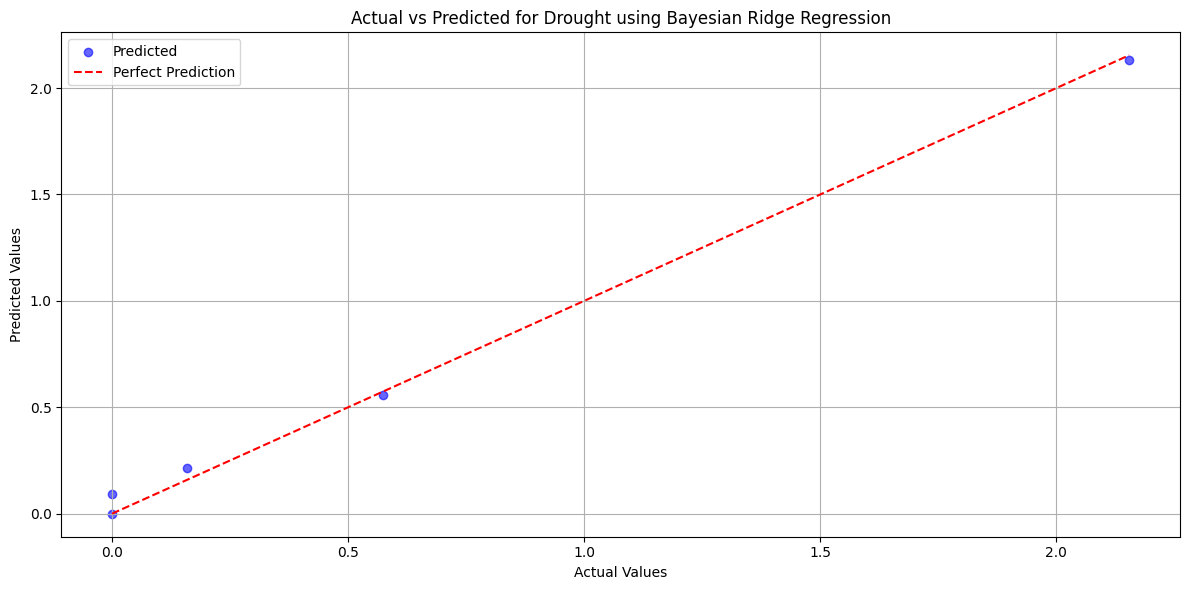

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import BayesianRidge

# Ensure target variable is numeric
data[target_column] = pd.to_numeric(data[target_column], errors='coerce')

# Drop rows with NaN target values
data = data.dropna(subset=[target_column])

# Define features (X) and target (y)
X = data.drop(columns=[target_column])  # Features
y = data[target_column]  # Target

# Ensure all features are numeric (already hot-encoded)
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Step 3: Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Cross-Validation Setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation predictions
cv_predictions = cross_val_predict(BayesianRidge(), X_train, y_train, cv=kf)

# Cross-validation evaluation
cv_rmse = np.sqrt(mean_squared_error(y_train, cv_predictions))
cv_mae = mean_absolute_error(y_train, cv_predictions)
print(f"Cross-Validation RMSE: {cv_rmse:.2f}, MAE: {cv_mae:.2f}")

# Step 5: Train Bayesian Ridge Regression Model on Full Training Data
model = BayesianRidge()
model.fit(X_train, y_train)

# Step 6: Make Predictions and Evaluate on Test Set
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"Test Set RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# Step 7: Visualize Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title("Actual vs Predicted for Drought using Bayesian Ridge Regression")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   AID Contribution ('000 US$)          25 non-null     float64
 1   Magnitude                            1 non-null      float64
 2   Start Year                           25 non-null     int64  
 3   Start Month                          25 non-null     int64  
 4   Total Deaths                         25 non-null     float64
 5   Total Affected                       25 non-null     float64
 6   Reconstruction Costs (billion $)     25 non-null     float64
 7   Insured Damage (billion $)           25 non-null     float64
 8   Total Damage (billion $)             25 non-null     float64
 9   Total Damage, Adjusted (billion $)   25 non-null     float64
 10  CPI                                  24 non-null     float64
 11  Associated Types

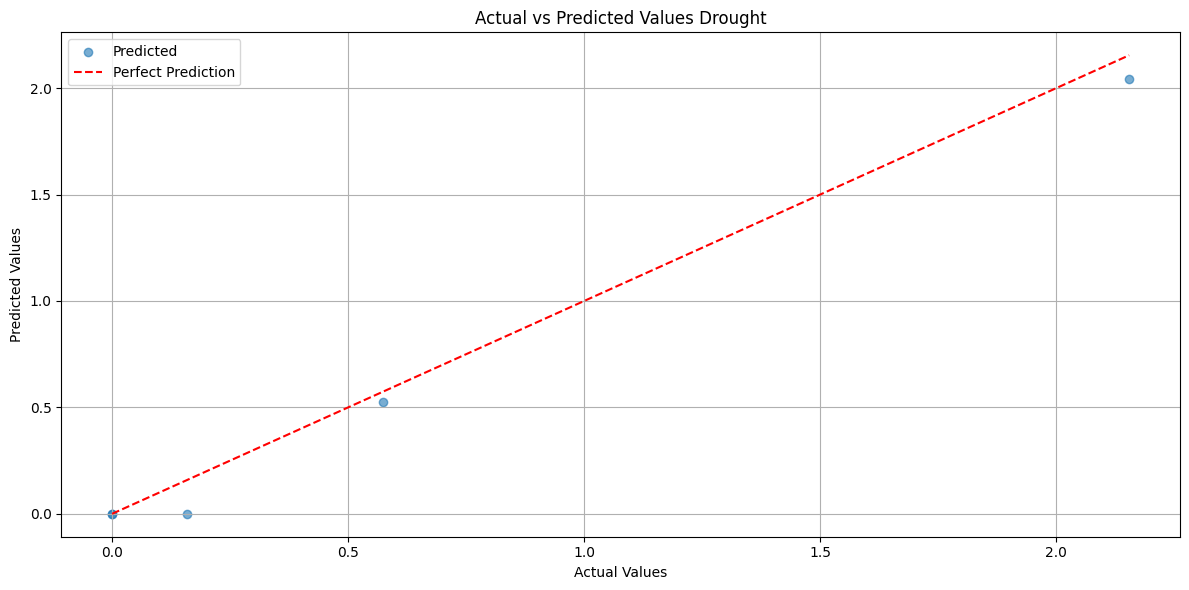


Model Evaluation Summary:
                     Model   CV RMSE  Test RMSE
0  Gradient Boosting (XGB)  0.377296   0.089538


In [10]:
###Gradient Boosting Model

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Load and validate dataset
print("Dataset Overview:")
print(data.info())

# Define the target variable and features
target_column = "Total Damage, Adjusted (billion $)"
X = data.drop(columns=[target_column])
y = data[target_column]

# Ensure all features are numeric
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Regressor
gbm_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    tree_method='auto'  # Use an appropriate tree method
)

# Custom Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

print("\nPerforming Cross-Validation...")
for train_index, val_index in kf.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

    gbm_model.fit(X_train_cv, y_train_cv)
    preds = gbm_model.predict(X_val_cv)
    cv_rmse = np.sqrt(mean_squared_error(y_val_cv, preds))
    cv_scores.append(cv_rmse)

avg_cv_rmse = np.mean(cv_scores)
print(f"Average CV RMSE: {avg_cv_rmse:.2f}")

# Train on the full training set and evaluate on the test set
print("\nTraining on full training set...")
gbm_model.fit(X_train, y_train)
test_preds = gbm_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
print(f"Test RMSE: {test_rmse:.2f}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, test_preds, alpha=0.6, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title("Actual vs Predicted Values Drought")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save results for summary
results = {
    'Model': ['Gradient Boosting (XGB)'],
    'CV RMSE': [avg_cv_rmse],
    'Test RMSE': [test_rmse]
}

results_df = pd.DataFrame(results)
print("\nModel Evaluation Summary:")
print(results_df)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

# Step 1: Load and Validate Dataset
print("Dataset Overview:")
print(data.info())
print(data.describe())

# Step 2: Define Features and Target Variable
target_column = "Total Damage (billion $)"
X = data.drop(columns=[target_column])  # Features
y = data[target_column]  # Target

# Ensure all features are numeric
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Step 3: Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Define Cross-Validation Function
def cross_validate_nn(X, y, neurons_1, neurons_2, neurons_3, folds=5):
    """Performs K-Fold cross-validation on a neural network with the specified architecture."""
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    rmse_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Build the Neural Network Model
        model = keras.Sequential([
            layers.Input(shape=(X_train.shape[1],)),
            layers.Dense(neurons_1, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(neurons_2, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(neurons_3, activation='relu'),
            layers.Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train the model
        model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

        # Predict on validation set
        y_pred = model.predict(X_val).flatten()
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

# Step 5: Grid Search Over Neural Network Configurations
layer_options = [32, 64, 128]  # Possible number of neurons in each layer
results = []

print("Starting Grid Search...")
for neurons_1 in layer_options:
    for neurons_2 in layer_options:
        for neurons_3 in layer_options:
            print(f"Evaluating model with layers: {neurons_1}, {neurons_2}, {neurons_3}")
            avg_rmse = cross_validate_nn(X_scaled, y.values, neurons_1, neurons_2, neurons_3, folds=5)
            results.append({
                'Neurons_Layer_1': neurons_1,
                'Neurons_Layer_2': neurons_2,
                'Neurons_Layer_3': neurons_3,
                'Avg RMSE': avg_rmse
            })

# Step 6: Summarize Results
results_df = pd.DataFrame(results)
best_model = results_df.loc[results_df['Avg RMSE'].idxmin()]
print("\nBest Model Configuration:")
print(best_model)

# Step 7: Train Best Model on Full Training Set
best_neurons_1 = int(best_model['Neurons_Layer_1'])
best_neurons_2 = int(best_model['Neurons_Layer_2'])
best_neurons_3 = int(best_model['Neurons_Layer_3'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the Best Neural Network Model
final_model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(best_neurons_1, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(best_neurons_2, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(best_neurons_3, activation='relu'),
    layers.Dense(1)
])
final_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Final Model
final_model.fit(X_train, y_train, epochs=500, batch_size=16, verbose=1)

# Step 8: Evaluate the Final Model on Test Set
y_pred = final_model.predict(X_test).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nFinal Model Test RMSE: {rmse:.2f}")

# Step 9: Visualize Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title("Actual vs Predicted Drought K-Fold cross-validation")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
